### 1. Install Packages

In [1]:
!pip3 install numpy scipy matplotlib autograd==1.1.13 tick numpydoc==0.7.0

You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 2. Import Packages

In [2]:
import autograd.scipy.special as special
from util import *
import equations
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad
from vbhp import fit_vbhp
import wp
from scipy.optimize import minimize
from tick.hawkes import HawkesKernelTimeFunc, SimuHawkes
from tick.base import TimeFunction

/home/rzhang/anaconda3/lib/python3.6/site-packages/autograd/core.py:120: UserWarning: 
------------------------------
    defgrad is deprecated!
------------------------------
Use defvjp instead ("define vector-Jacobian product").
The interface is a little different - look at
autograd/numpy/numpy_grads.py for examples.

  warnings.warn(defgrad_deprecated)
/home/rzhang/anaconda3/lib/python3.6/site-packages/autograd/core.py:120: UserWarning: 
------------------------------
    defgrad is deprecated!
------------------------------
Use defvjp instead ("define vector-Jacobian product").
The interface is a little different - look at
autograd/numpy/numpy_grads.py for examples.

  warnings.warn(defgrad_deprecated)
/home/rzhang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_con

### 3. Define a Triggering Kernel

Define a triggering kernel: $$\phi(t)=\begin{cases}0.9[\sin(3t)+1], & t\in [0,\pi) \\ 0, & \text{otherwise} \end{cases}.$$

In [3]:
ts = np.linspace(0, np.pi / 2, 512) # support
f = lambda t: (np.sin(3 * t)+1)*0.9
ys = f(ts)
kernel = HawkesKernelTimeFunc(t_values=ts, y_values=ys) # for simulation

#### plot the triggering kernel

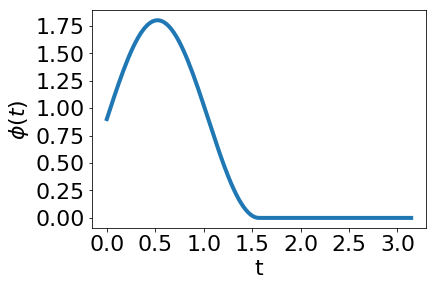

In [4]:
fontsize=22
xplot = np.linspace(0,np.pi,128)
yplot = kernel.get_values(xplot)
plt.plot(xplot,yplot,linewidth=4)
plt.xlabel('t',fontsize=fontsize)
plt.ylabel('$\phi(t)$',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

### 4. Simulate a Hawkes Process
The background intensity is $\mu = 10$.

In [5]:
run_time = np.pi
mu = 10
hawkes = SimuHawkes(baseline=[mu], verbose=False, force_simulation=True, end_time=run_time, seed=1320)
hawkes.set_kernel(0, 0, kernel)
hawkes.simulate()
times = np.array(hawkes.timestamps)
print('The generated time points: ')
for i in range(9):
    print('{0:.3f}'.format(times[0,i]),end=', ')
print('...',end='')
for i in range(4):
    print(', {0:.3f}'.format(times[0,len(times)-1-i]),end='')
print(' ({} points).'.format(times.shape[1]))

The generated time points: 
0.029, 0.190, 0.217, 0.245, 0.322, 0.375, 0.379, 0.435, 0.570, ..., 0.029, 3.141, 3.133, 3.133 (498 points).


### 5. Infer the Posterior Triggering Kernel by VBHP 
Search hyper-parameters over $[0.01, 10]^2$, exploit 10 inducing points and use $[0, 1.4]$ as the triggering kernel support.

In [8]:
nparams = 8
alphas = np.logspace(-2, 1, nparams)
gammas = np.logspace(-2, 1, nparams)

nz = 10
zmax = 3.14
support = 1.4

# Non-parallel
# l2s =[fit_vbhp([hp], nz, zmax, run_time, 'sin', False, ga,alpha,support) for ga in gammas for alpha in alphas]

# Parallel
from joblib import Parallel, delayed
res = Parallel(n_jobs=7)(delayed(fit_vbhp)([times], nz, zmax, run_time, 'sin', False, ga,alpha,support) for ga in gammas for alpha in alphas)

#### Select the posterior triggering kernel by maximizing the marginal likelihood and plot it.

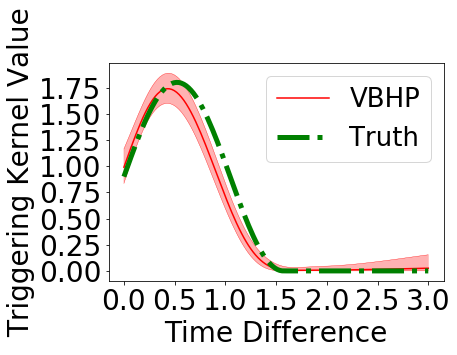

In [12]:
mls = np.array([e[0] for e in res])
ind = np.argwhere(mls.max()==mls)[0,0]
paramslin = res[ind][1]
mls = mls.reshape((nparams,nparams))
ga_alpha = np.argwhere(mls.max()==mls)[0]
gamma = gammas[ga_alpha[0]]
alpha = alphas[ga_alpha[1]]
xplot = np.linspace(0,3,128).reshape((1,-1))
fontsize=28
params = unlinearise_params(paramslin)
z = np.linspace(1e-6,zmax,nz).reshape((1,-1))
taus = [np.array([(times[0, i] - times[0, :i])[times[0, i] - times[0, :i]<=support]]) for i in range(1, times.shape[1])]
precomp = equations.precompute(z, gamma, alpha, run_time, times[0],taus)
mutilde, sigmatilde2, Sigmatilde = equations.predictive(params.L, params.m,
                                   precomp,equations.precompute_predictive(xplot,z,gamma,alpha))
ticksize = 28
quantiles = squared_normal_quantiles(mutilde, sigmatilde2 ** 0.5, [0.10, 0.5, 0.9], double=True)
wp.gpplot(xplot.flatten(), quantiles[:, 1], quantiles[:, 0], quantiles[:, 2],
          fillcol='r', edgecol='r',mulabel='VBHP')
plt.plot(xplot.flatten(), kernel.get_values(xplot.flatten()),'-.',color='g',label='Truth',linewidth=5)

plt.legend(prop={'size': 26})
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlabel('Time Difference',fontsize=fontsize)
plt.ylabel('Triggering Kernel Value',fontsize=fontsize)
plt.show()